In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database Connection Details
db_user = "root"
db_password = "12345"
db_host = "localhost"
db_trips = "trips_db"
db_targets = "targets_db"

# Create SQLAlchemy Engines for both databases
engine_trips = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")
engine_targets = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_targets}")


c:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Function to fetch table names and display the head
def show_table_heads(engine, database_name):
    print(f"\n--- Showing Tables from Database: {database_name} ---")
    
    # Query to get table names
    query_tables = "SHOW TABLES;"
    
    # Fetch all table names
    tables = pd.read_sql(query_tables, engine)
    table_names = tables.iloc[:, 0].tolist()  # Extract table names from the first column
    
    # Loop through each table and fetch first 5 rows
    for table in table_names:
        print(f"\nTable: {table}")
        query_head = f"SELECT * FROM {table} LIMIT 5;"
        try:
            df = pd.read_sql(query_head, engine)
            print(df.head(1))
        except Exception as e:
            print(f"Error retrieving data from table {table}: {e}")

# Create SQLAlchemy Engines for both databases
engine_trips = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")
engine_targets = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_targets}")

# Show heads of all tables from trips_db
show_table_heads(engine_trips, db_trips)



# Close the engines
engine_trips.dispose()
engine_targets.dispose()



--- Showing Tables from Database: trips_db ---

Table: dim_city
  city_id      city_name
0    AP01  Visakhapatnam

Table: dim_date
         date start_of_month month_name day_type
0  2024-01-01     2024-01-01    January  Weekday

Table: dim_repeat_trip_distribution
        month city_id trip_count  repeat_passenger_count
0  2024-01-01    AP01   10-Trips                       7

Table: fact_passenger_summary
        month city_id  total_passengers  new_passengers  repeat_passengers
0  2024-01-01    AP01              3163            2513                650

Table: fact_trips
                trip_id        date city_id passenger_type  \
0  TRPCHA24010100386a73  2024-01-01    CH01       repeated   

   distance_travelled_km  fare_amount  passenger_rating  driver_rating  
0                     25          251                 8              9  


In [3]:
# Show heads of all tables from targets_db
show_table_heads(engine_targets, db_targets)


--- Showing Tables from Database: targets_db ---

Table: city_target_passenger_rating
  city_id  target_avg_passenger_rating
0    AP01                          8.5

Table: monthly_target_new_passengers
        month city_id  target_new_passengers
0  2024-01-01    AP01                   2500

Table: monthly_target_trips
        month city_id  total_target_trips
0  2024-01-01    AP01                4500


Top and bottom Cities by Trip Volume Variance

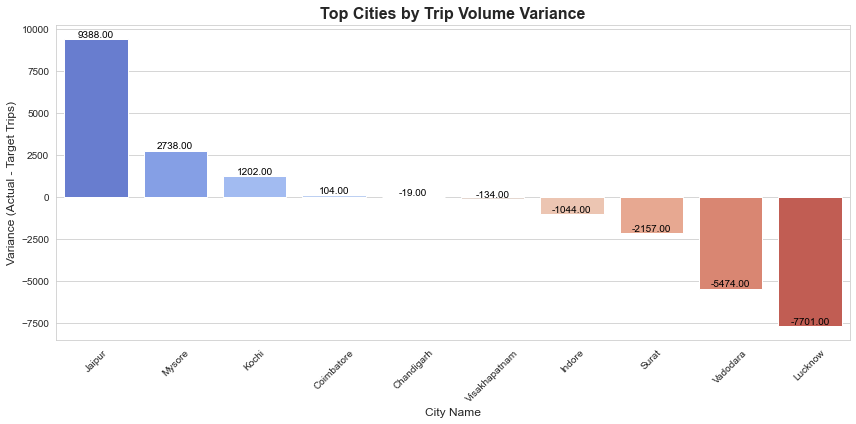

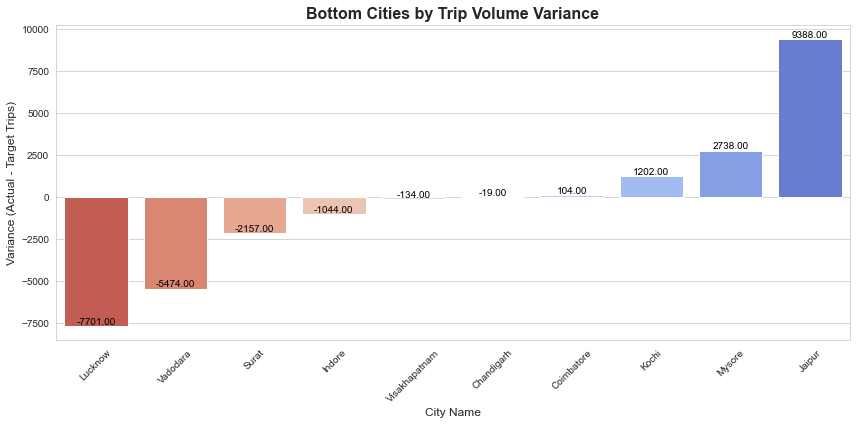

In [ ]:
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

# SQL Queries
query_top_cities = """
WITH AggregatedTargets AS (
    SELECT 
        city_id,
        SUM(total_target_trips) AS total_target_trips
    FROM targets_db.monthly_target_trips
    GROUP BY city_id
)
SELECT 
    c.city_name,
    COUNT(t.trip_id) AS actual_trip_count,
    at.total_target_trips,
    (COUNT(t.trip_id) - at.total_target_trips) AS variance
FROM trips_db.fact_trips t
JOIN trips_db.dim_city c 
    ON t.city_id = c.city_id
JOIN AggregatedTargets at 
    ON t.city_id = at.city_id
GROUP BY c.city_name, at.total_target_trips
ORDER BY variance DESC;
"""

query_bottom_cities = """
WITH AggregatedTargets AS (
    SELECT 
        city_id,
        SUM(total_target_trips) AS total_target_trips
    FROM targets_db.monthly_target_trips
    GROUP BY city_id
)
SELECT 
    c.city_name,
    COUNT(t.trip_id) AS actual_trip_count,
    at.total_target_trips,
    (COUNT(t.trip_id) - at.total_target_trips) AS variance
FROM trips_db.fact_trips t
JOIN trips_db.dim_city c 
    ON t.city_id = c.city_id
JOIN AggregatedTargets at 
    ON t.city_id = at.city_id
GROUP BY c.city_name, at.total_target_trips
ORDER BY variance ASC;
"""

# Load data into Pandas DataFrames
df_top_cities = pd.read_sql(query_top_cities, engine)
df_bottom_cities = pd.read_sql(query_bottom_cities, engine)

# Close the database connection
engine.dispose()

# # Display the data
# print("Top Cities by Variance:")
# print(df_top_cities.head())

# print("Bottom Cities by Variance:")
# print(df_bottom_cities.head())


# Set Seaborn modern style and font
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12, "axes.titlesize": 14, "axes.labelsize": 12})

# Custom function to add bar labels
def add_bar_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):  # Avoid NaN values
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=10, color='black')

# Visualization 1: Top Cities by Variance
plt.figure(figsize=(12, 6))
top_palette = sns.color_palette("coolwarm", len(df_top_cities))  # Gradient palette
ax1 = sns.barplot(
    data=df_top_cities, 
    x="city_name", 
    y="variance", 
    hue="city_name",  # Assign 'city_name' to hue
    palette=top_palette,
    legend=False
)
add_bar_labels(ax1)  # Add labels

plt.title("Top Cities by Trip Volume Variance", fontsize=16, weight='bold')
plt.xlabel("City Name")
plt.ylabel("Variance (Actual - Target Trips)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # Visualization 2: Bottom Cities by Variance
# plt.figure(figsize=(12, 6))
# bottom_palette = sns.color_palette("coolwarm_r", len(df_bottom_cities))  # Gradient palette reverse
# ax2 = sns.barplot(
#     data=df_bottom_cities, 
#     x="city_name", 
#     y="variance", 
#     hue="city_name",  # Assign 'city_name' to hue
#     palette=bottom_palette,
#     legend=False
# )
# add_bar_labels(ax2)  # Add labels

# plt.title("Bottom Cities by Trip Volume Variance", fontsize=16, weight='bold')
# plt.xlabel("City Name")
# plt.ylabel("Variance (Actual - Target Trips)")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()




Trip Distance & Fare Analysis

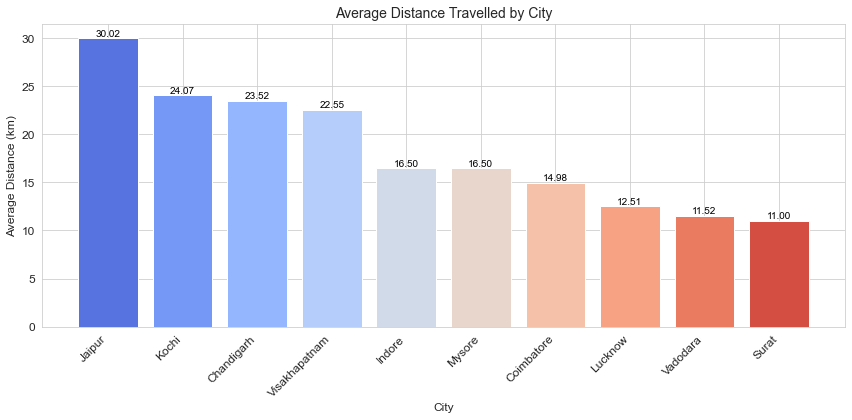

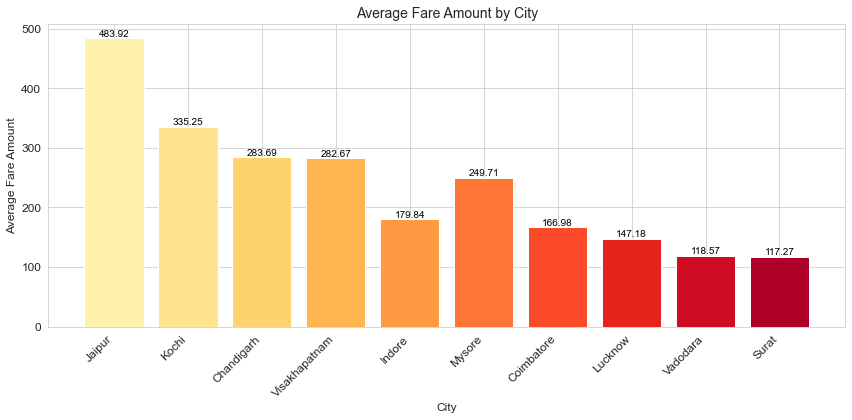

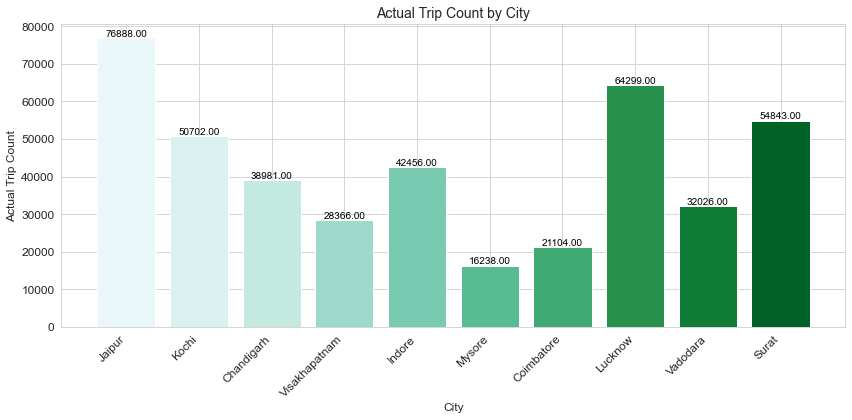

In [5]:
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")


query = """
SELECT 
    c.city_name,
    COUNT(t.trip_id) AS actual_trip_count,
    ROUND(AVG(t.distance_travelled_km), 2) AS avg_distance_km,
    ROUND(AVG(t.fare_amount), 2) AS avg_fare_amount
FROM trips_db.fact_trips t
JOIN trips_db.dim_city c 
    ON t.city_id = c.city_id
GROUP BY c.city_name
ORDER BY avg_distance_km DESC;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

engine.dispose()

# Set Seaborn modern style and font
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12, "axes.titlesize": 14, "axes.labelsize": 12})

# Custom function to add bar labels
def add_bar_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only add label for positive bars
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=10, color='black')

# Step 4: Visualize the data using Matplotlib
plt.figure(figsize=(12, 6))

# Plot Average Distance by City
top_palette = sns.color_palette("coolwarm", len(df))  # Gradient palette
ax1 = plt.bar(df['city_name'], df['avg_distance_km'], color=top_palette)
plt.xlabel('City')
plt.ylabel('Average Distance (km)')
plt.title('Average Distance Travelled by City')
plt.xticks(rotation=45, ha='right')  # Rotate city names for readability
add_bar_labels(plt.gca())  # Add labels on top of bars
plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Plot Average Fare by City
plt.figure(figsize=(12, 6))
bottom_palette = sns.color_palette("YlOrRd", len(df))  # Gradient palette for fares
ax2 = plt.bar(df['city_name'], df['avg_fare_amount'], color=bottom_palette)
plt.xlabel('City')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by City')
plt.xticks(rotation=45, ha='right')
add_bar_labels(plt.gca())  # Add labels on top of bars
plt.tight_layout()
plt.show()

# Plot Actual Trip Count by City
plt.figure(figsize=(12, 6))
green_palette = sns.color_palette("BuGn", len(df))  # Green gradient for trip count
ax3 = plt.bar(df['city_name'], df['actual_trip_count'], color=green_palette)
plt.xlabel('City')
plt.ylabel('Actual Trip Count')
plt.title('Actual Trip Count by City')
plt.xticks(rotation=45, ha='right')
add_bar_labels(plt.gca())  # Add labels on top of bars
plt.tight_layout()
plt.show()


Average Rating by City and Passenger Type

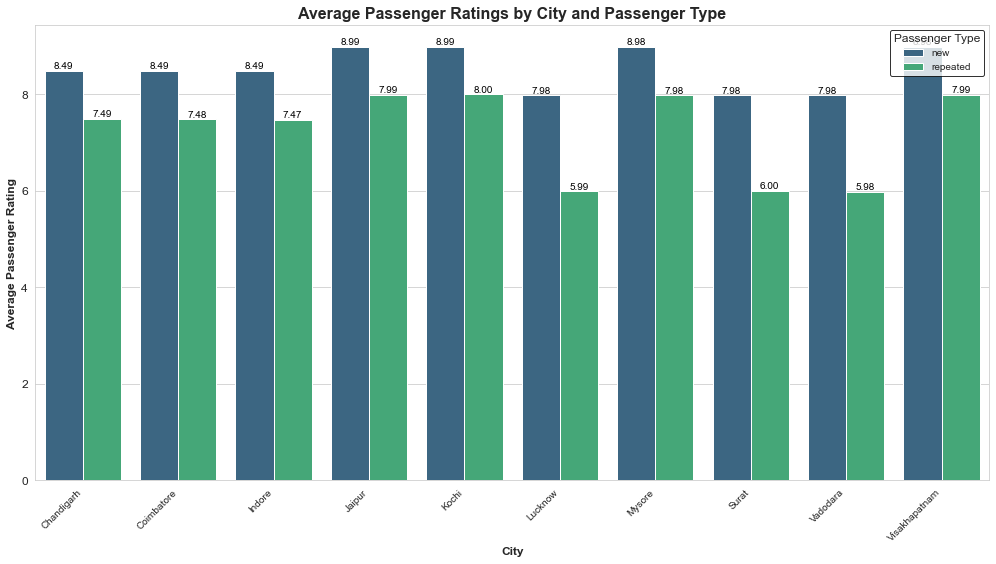

In [6]:
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

# Step 2: Define the SQL query
query = """
SELECT 
    c.city_name,
    t.passenger_type,
    ROUND(AVG(t.passenger_rating), 2) AS avg_passenger_rating
FROM trips_db.fact_trips t
JOIN trips_db.dim_city c 
    ON t.city_id = c.city_id
WHERE t.passenger_rating IS NOT NULL  
GROUP BY c.city_name, t.passenger_type
ORDER BY c.city_name, avg_passenger_rating DESC;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)
engine.dispose()

# Set modern Seaborn style
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12, "axes.titlesize": 14, "axes.labelsize": 12})

# Custom function to add bar labels
def add_bar_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only add label for positive values
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=10, color='black')

# Plot Average Passenger Ratings by City and Passenger Type
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df,
    x="city_name",
    y="avg_passenger_rating",
    hue="passenger_type",
    palette="viridis"  # Updated palette for a modern look
)

# Add labels to the bars
add_bar_labels(ax)

# Customize plot
plt.xlabel("City", fontsize=12, weight='bold')
plt.ylabel("Average Passenger Rating", fontsize=12, weight='bold')
plt.title("Average Passenger Ratings by City and Passenger Type", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(
    title="Passenger Type", 
    loc="upper right", 
    fontsize=10, 
    title_fontsize=12, 
    frameon=True, 
    edgecolor="black"
)
plt.tight_layout()  
plt.show()


Peak and Low Demand Month by City

<ipython-input-17-ff0653739798>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


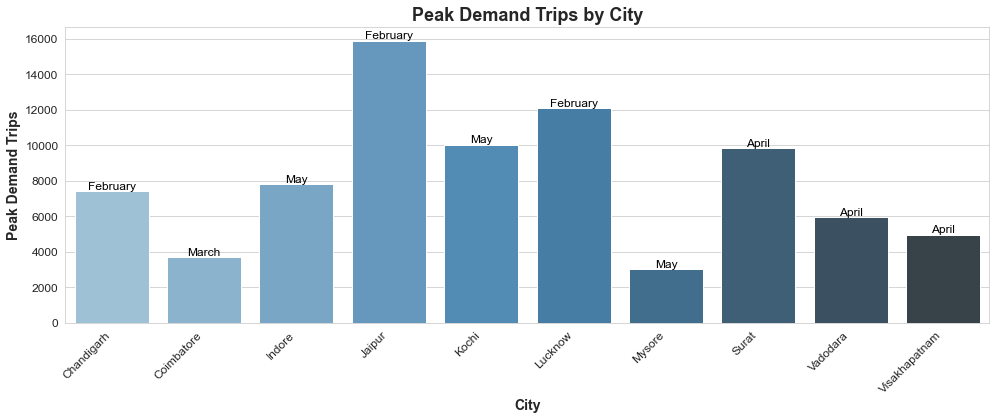

<ipython-input-17-ff0653739798>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


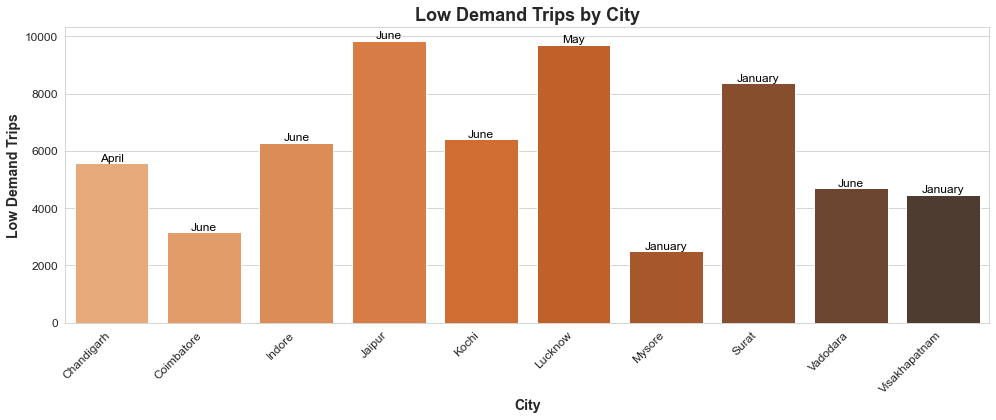

In [17]:
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

query = """
WITH monthly_trip_counts AS (
    SELECT 
        c.city_name,
        DATE_FORMAT(t.date, '%%Y-%%m') AS month,  
        COUNT(t.trip_id) AS total_trips
    FROM trips_db.fact_trips t
    JOIN trips_db.dim_city c 
        ON t.city_id = c.city_id
    GROUP BY c.city_name, DATE_FORMAT(t.date, '%%Y-%%m')
)
SELECT 
    city_name,
    MAX(CASE WHEN total_trips = max_trips THEN month END) AS peak_demand_month,
    MAX(total_trips) AS peak_demand_trips,
    MIN(CASE WHEN total_trips = min_trips THEN month END) AS low_demand_month,
    MIN(total_trips) AS low_demand_trips
FROM (
    SELECT 
        city_name,
        month,
        total_trips,
        MAX(total_trips) OVER (PARTITION BY city_name) AS max_trips,
        MIN(total_trips) OVER (PARTITION BY city_name) AS min_trips
    FROM monthly_trip_counts
) ranked_data
GROUP BY city_name;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

engine.dispose()
# Convert 'peak_demand_month' and 'low_demand_month' to display only month names
df['peak_demand_month'] = pd.to_datetime(df['peak_demand_month'], format='%Y-%m').dt.strftime('%B')
df['low_demand_month'] = pd.to_datetime(df['low_demand_month'], format='%Y-%m').dt.strftime('%B')

# Custom function to add bar labels with month names
def add_bar_labels_with_month(ax, y_col, month_col):
    for index, row in df.iterrows():
        ax.text(
            index, 
            row[y_col] + 0.5,  # Slightly offset the text for clarity
            f"{row[month_col]}",
            ha='center',
            va='bottom',
            fontsize=12,  # Slightly larger font for better readability
            color='black'
        )

# Peak Demand Visualization
plt.figure(figsize=(14, 6))
ax1 = sns.barplot(
    x='city_name',
    y='peak_demand_trips',
    data=df,
    palette='Blues_d'  # Light blue color palette for peak demand
)
add_bar_labels_with_month(ax1, 'peak_demand_trips', 'peak_demand_month')
plt.xlabel('City', fontsize=14, weight='bold')
plt.ylabel('Peak Demand Trips', fontsize=14, weight='bold')
plt.title('Peak Demand Trips by City', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)  # Larger font size for x-ticks
plt.tight_layout()
plt.show()

# Low Demand Visualization
plt.figure(figsize=(14, 6))
ax2 = sns.barplot(
    x='city_name',
    y='low_demand_trips',
    data=df,
    palette='Oranges_d'  # Light orange color palette for low demand
)
add_bar_labels_with_month(ax2, 'low_demand_trips', 'low_demand_month')
plt.xlabel('City', fontsize=14, weight='bold')
plt.ylabel('Low Demand Trips', fontsize=14, weight='bold')
plt.title('Low Demand Trips by City', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)  # Larger font size for x-ticks
plt.tight_layout()
plt.show()


Weekday vs Weekend Trip Demand by City

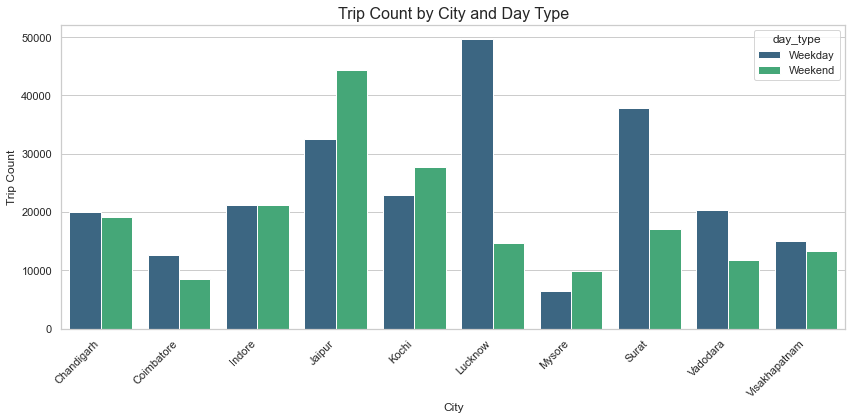

In [18]:

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

# Step 2: Define the SQL query
query = """
SELECT 
    c.city_name,
    d.day_type,
    COUNT(t.trip_id) AS trip_count
FROM trips_db.fact_trips t
JOIN trips_db.dim_city c 
    ON t.city_id = c.city_id
JOIN trips_db.dim_date d 
    ON t.date = d.date
GROUP BY c.city_name, d.day_type
ORDER BY c.city_name, d.day_type;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

# Step 4: Visualize the data

# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a barplot to visualize the trip counts by city and day type
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="city_name", y="trip_count", hue="day_type", data=df, palette="viridis")

# Add labels to the plot
ax.set_title('Trip Count by City and Day Type', fontsize=16)
ax.set_xlabel('City', fontsize=12)
ax.set_ylabel('Trip Count', fontsize=12)
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()


Repeat Passenger Count by City and Trip Count

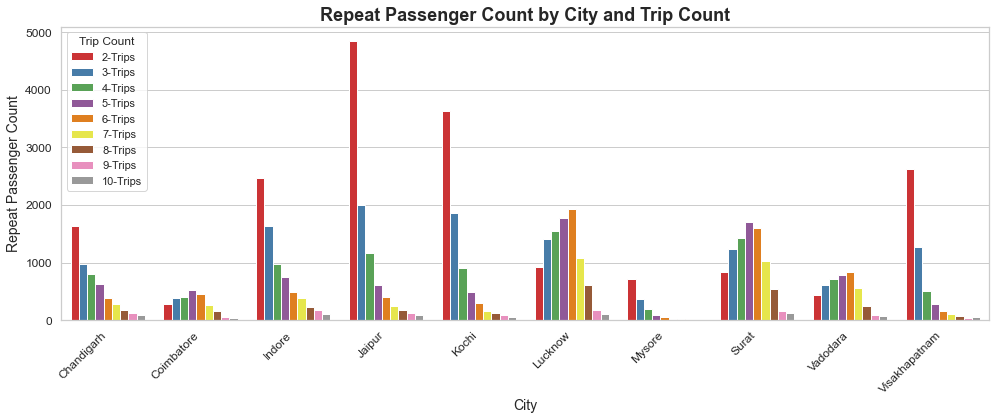

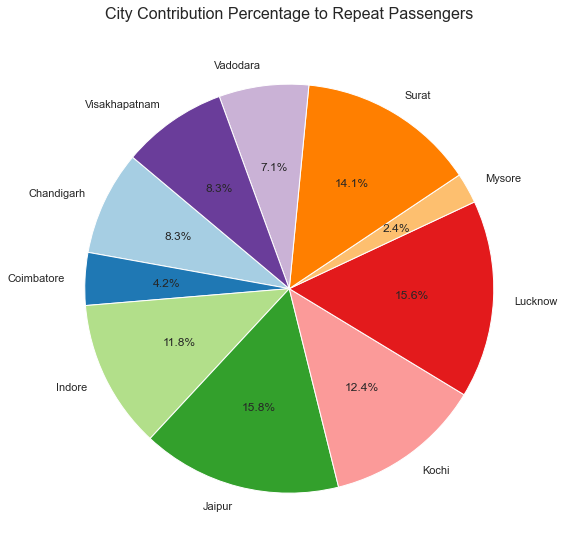

In [21]:

# Step 1: Set up the database connection
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

query = """
SELECT 
    c.city_name,
    SUM(CASE WHEN r.trip_count = '2-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "2-Trips",
    SUM(CASE WHEN r.trip_count = '3-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "3-Trips",
    SUM(CASE WHEN r.trip_count = '4-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "4-Trips",
    SUM(CASE WHEN r.trip_count = '5-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "5-Trips",
    SUM(CASE WHEN r.trip_count = '6-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "6-Trips",
    SUM(CASE WHEN r.trip_count = '7-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "7-Trips",
    SUM(CASE WHEN r.trip_count = '8-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "8-Trips",
    SUM(CASE WHEN r.trip_count = '9-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "9-Trips",
    SUM(CASE WHEN r.trip_count = '10-Trips' THEN r.repeat_passenger_count ELSE 0 END) AS "10-Trips",
    ROUND(SUM(r.repeat_passenger_count) * 100.0 / SUM(SUM(r.repeat_passenger_count)) OVER (), 2) AS city_contribution_percentage
FROM trips_db.dim_repeat_trip_distribution r
JOIN trips_db.dim_city c 
    ON r.city_id = c.city_id
GROUP BY c.city_name
ORDER BY c.city_name;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

sns.set(style="whitegrid")

# Create a barplot to visualize the trip counts by city for different trip ranges
trip_columns = ['2-Trips', '3-Trips', '4-Trips', '5-Trips', '6-Trips', '7-Trips', '8-Trips', '9-Trips', '10-Trips']
df_melted = df.melt(id_vars=["city_name"], value_vars=trip_columns, var_name="Trip Count", value_name="Repeat Passenger Count")

plt.figure(figsize=(14, 6))
ax = sns.barplot(x="city_name", y="Repeat Passenger Count", hue="Trip Count", data=df_melted, palette="Set1")

# Add labels to the plot
ax.set_title('Repeat Passenger Count by City and Trip Count', fontsize=18, weight='bold')
ax.set_xlabel('City', fontsize=14)
ax.set_ylabel('Repeat Passenger Count', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Adjusted font size for x-ticks
plt.yticks(fontsize=12)  # Adjusted font size for y-ticks

# Show the plot
plt.tight_layout()
plt.show()



# Extract city names and contribution percentages
city_names = df['city_name']
contribution_percentages = df['city_contribution_percentage']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(contribution_percentages, labels=city_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('City Contribution Percentage to Repeat Passengers', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the plot
plt.tight_layout()
plt.show()


Monthly Target Achievement Analysis for Key Metrics

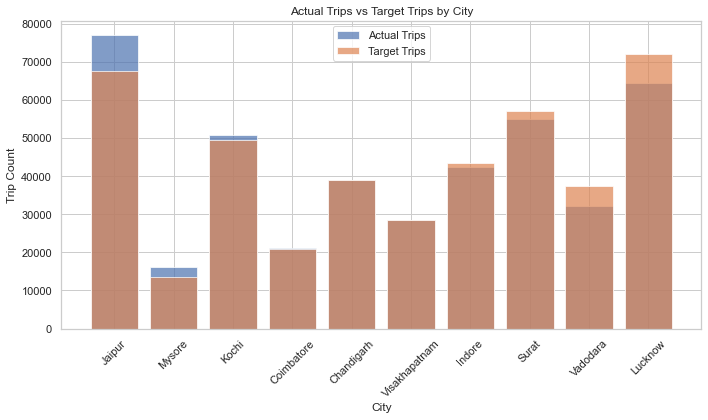

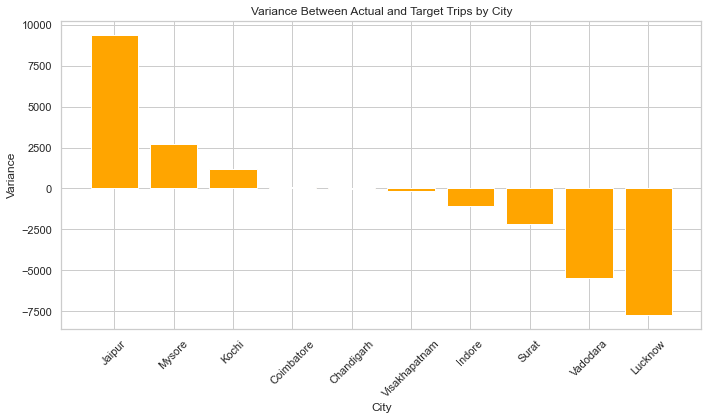

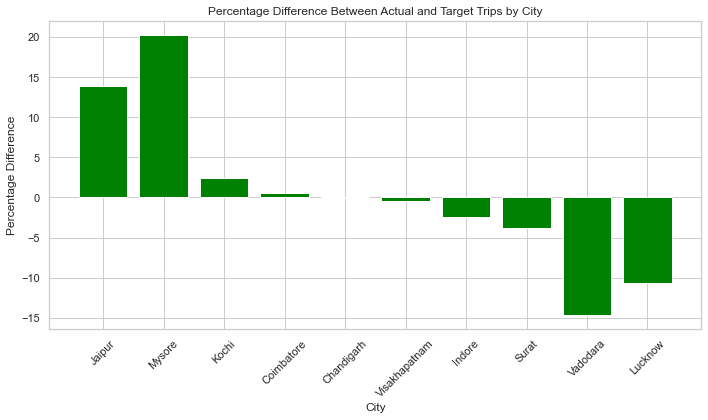

In [22]:

query = """
WITH AggregatedTargets AS (
    SELECT 
        city_id,
        SUM(total_target_trips) AS total_target_trips -- Aggregate target trips for each city
    FROM targets_db.monthly_target_trips
    GROUP BY city_id
)
SELECT 
    c.city_name,
    COUNT(t.trip_id) AS actual_trip_count,
    at.total_target_trips,
    (COUNT(t.trip_id) - at.total_target_trips) AS variance,
    CASE 
        WHEN COUNT(t.trip_id) >= at.total_target_trips THEN 'Met/Exceeded'
        ELSE 'Missed'
    END AS target_status,
    ROUND(((COUNT(t.trip_id) - at.total_target_trips) * 100.0) / at.total_target_trips, 2) AS percentage_difference
FROM trips_db.fact_trips t
JOIN trips_db.dim_city c 
    ON t.city_id = c.city_id
JOIN AggregatedTargets at 
    ON t.city_id = at.city_id
GROUP BY c.city_name, at.total_target_trips
ORDER BY variance DESC;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

# Step 4: Create a bar plot to show actual trips vs target trips and variance

# Plot for Actual Trips vs Target Trips
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['actual_trip_count'], label='Actual Trips', alpha=0.7)
plt.bar(df['city_name'], df['total_target_trips'], label='Target Trips', alpha=0.7)
plt.xlabel('City')
plt.ylabel('Trip Count')
plt.title('Actual Trips vs Target Trips by City')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Variance
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['variance'], color='orange')
plt.xlabel('City')
plt.ylabel('Variance')
plt.title('Variance Between Actual and Target Trips by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Percentage Difference
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['percentage_difference'], color='green')
plt.xlabel('City')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference Between Actual and Target Trips by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Actual vs Target New Passengers by City

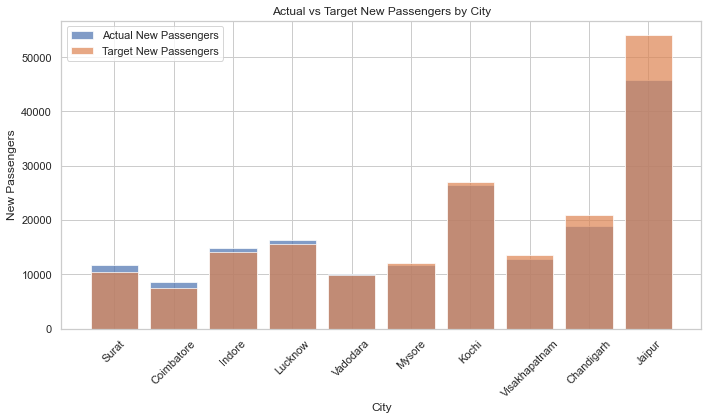

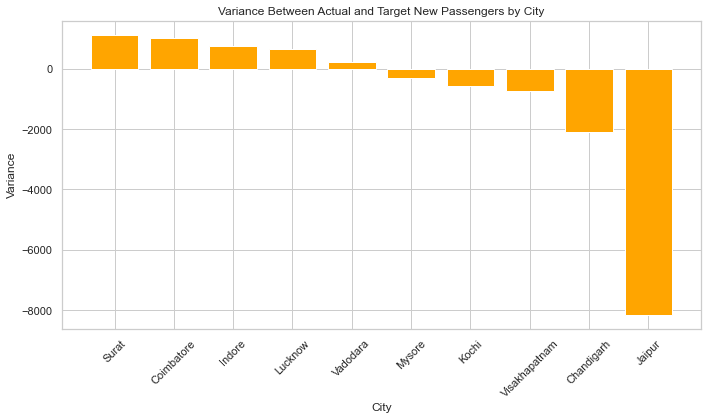

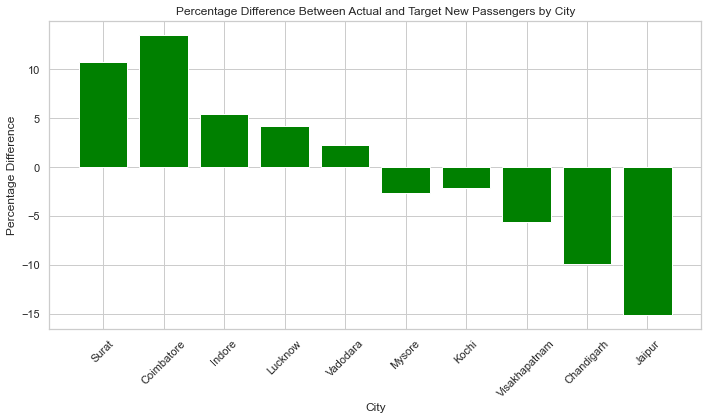

In [23]:

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

# Step 2: Define the SQL query
query = """
WITH AggregatedTargets AS (
    SELECT 
        city_id,
        SUM(target_new_passengers) AS total_target_new_passengers -- Aggregate target new passengers for each city
    FROM targets_db.monthly_target_new_passengers
    GROUP BY city_id
)
SELECT 
    c.city_name,
    SUM(fps.new_passengers) AS actual_new_passengers,
    at.total_target_new_passengers,
    (SUM(fps.new_passengers) - at.total_target_new_passengers) AS variance,
    CASE 
        WHEN SUM(fps.new_passengers) >= at.total_target_new_passengers THEN 'Met/Exceeded'
        ELSE 'Missed'
    END AS target_status,
    ROUND(((SUM(fps.new_passengers) - at.total_target_new_passengers) * 100.0) / at.total_target_new_passengers, 2) AS percentage_difference
FROM trips_db.fact_passenger_summary fps
JOIN trips_db.dim_city c 
    ON fps.city_id = c.city_id
JOIN AggregatedTargets at 
    ON fps.city_id = at.city_id
GROUP BY c.city_name, at.total_target_new_passengers
ORDER BY variance DESC;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

# Step 4: Create a bar plot for actual new passengers vs target new passengers

# Plot for Actual New Passengers vs Target New Passengers
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['actual_new_passengers'], label='Actual New Passengers', alpha=0.7)
plt.bar(df['city_name'], df['total_target_new_passengers'], label='Target New Passengers', alpha=0.7)
plt.xlabel('City')
plt.ylabel('New Passengers')
plt.title('Actual vs Target New Passengers by City')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Variance
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['variance'], color='orange')
plt.xlabel('City')
plt.ylabel('Variance')
plt.title('Variance Between Actual and Target New Passengers by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Percentage Difference
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['percentage_difference'], color='green')
plt.xlabel('City')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference Between Actual and Target New Passengers by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Actual vs Target Average Passenger Ratings by City

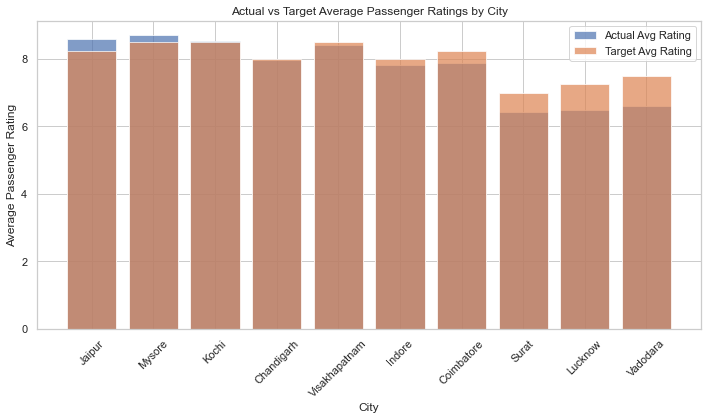

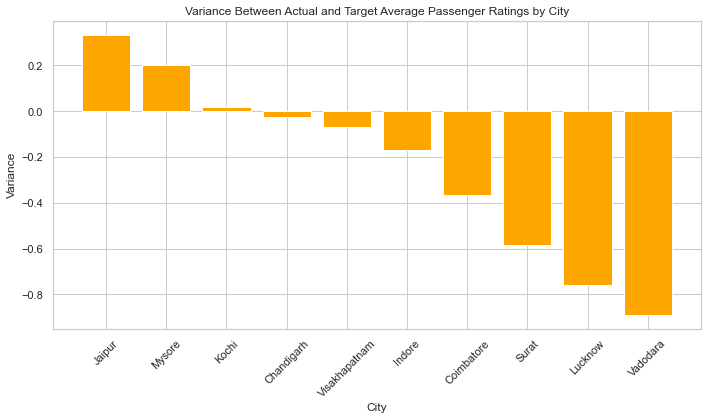

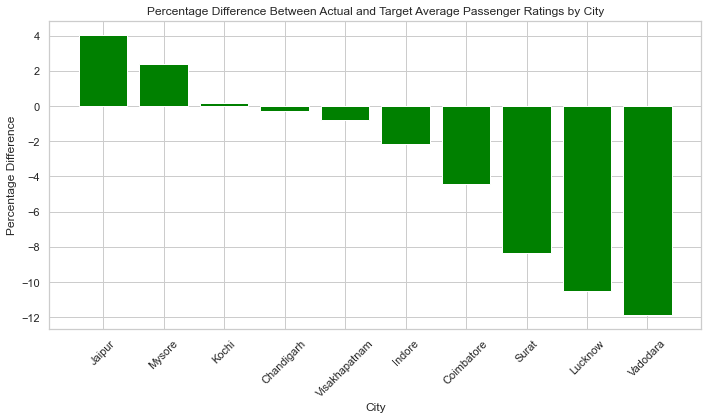

In [24]:

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

# Step 2: Define the SQL query
query = """
WITH AggregatedTargets AS (
    SELECT 
        city_id,
        AVG(target_avg_passenger_rating) AS total_target_avg_passenger_rating -- Aggregate target average passenger rating for each city
    FROM targets_db.city_target_passenger_rating
    GROUP BY city_id
)
SELECT 
    c.city_name,
    ROUND(AVG(t.passenger_rating), 2) AS actual_avg_passenger_rating,
    at.total_target_avg_passenger_rating,
    (AVG(t.passenger_rating) - at.total_target_avg_passenger_rating) AS variance,
    CASE 
        WHEN AVG(t.passenger_rating) >= at.total_target_avg_passenger_rating THEN 'Met/Exceeded'
        ELSE 'Missed'
    END AS target_status,
    ROUND(((AVG(t.passenger_rating) - at.total_target_avg_passenger_rating) * 100.0) / at.total_target_avg_passenger_rating, 2) AS percentage_difference
FROM trips_db.fact_trips t
JOIN trips_db.dim_city c 
    ON t.city_id = c.city_id
JOIN AggregatedTargets at 
    ON t.city_id = at.city_id
WHERE t.passenger_rating IS NOT NULL
GROUP BY c.city_name, at.total_target_avg_passenger_rating
ORDER BY percentage_difference DESC;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

# Step 4: Create a bar plot for actual average passenger ratings vs target average passenger ratings

# Plot for Actual vs Target Average Passenger Ratings
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['actual_avg_passenger_rating'], label='Actual Avg Rating', alpha=0.7)
plt.bar(df['city_name'], df['total_target_avg_passenger_rating'], label='Target Avg Rating', alpha=0.7)
plt.xlabel('City')
plt.ylabel('Average Passenger Rating')
plt.title('Actual vs Target Average Passenger Ratings by City')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Variance
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['variance'], color='orange')
plt.xlabel('City')
plt.ylabel('Variance')
plt.title('Variance Between Actual and Target Average Passenger Ratings by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Percentage Difference
plt.figure(figsize=(10, 6))
plt.bar(df['city_name'], df['percentage_difference'], color='green')
plt.xlabel('City')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference Between Actual and Target Average Passenger Ratings by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Repeat Passenger Ratio (RPR) Percentage by City

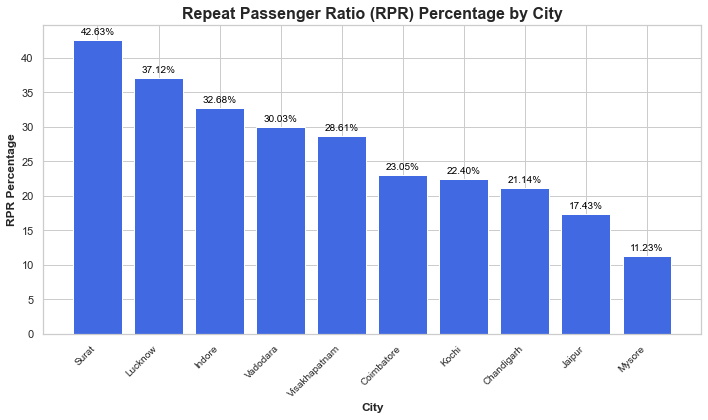

In [30]:

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

query = """
SELECT 
    c.city_name,
    SUM(fps.repeat_passengers) AS total_repeat_passengers,
    SUM(fps.total_passengers) AS total_passengers,
    ROUND((SUM(fps.repeat_passengers) * 100.0) / SUM(fps.total_passengers), 2) AS rpr_percentage
FROM trips_db.fact_passenger_summary fps
JOIN trips_db.dim_city c 
    ON fps.city_id = c.city_id
GROUP BY c.city_name
ORDER BY rpr_percentage DESC;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Close the connection
engine.dispose()

# Step 4: Create a bar plot for Repeat Passenger Ratio (RPR) percentage by city
plt.figure(figsize=(10, 6))
bars = plt.bar(df['city_name'], df['rpr_percentage'], color='royalblue')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # Position label at the center of the bar
        yval + 0.5,  # Slightly above the bar for clarity
        f'{yval:.2f}%',  # Display percentage with two decimal places
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Adding labels and title
plt.xlabel('City', fontsize=12, weight='bold')
plt.ylabel('RPR Percentage', fontsize=12, weight='bold')
plt.title('Repeat Passenger Ratio (RPR) Percentage by City', fontsize=16, weight='bold')

# Rotate x-ticks for readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Improve layout and show plot
plt.tight_layout()
plt.show()



Top and Bottom 5 Cities Based on RPR% 6 Months period

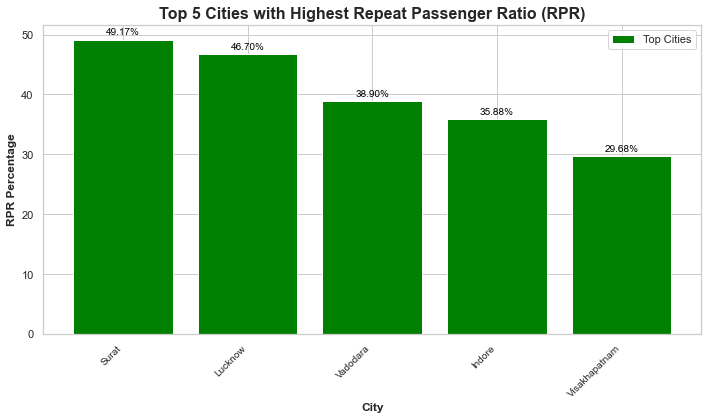

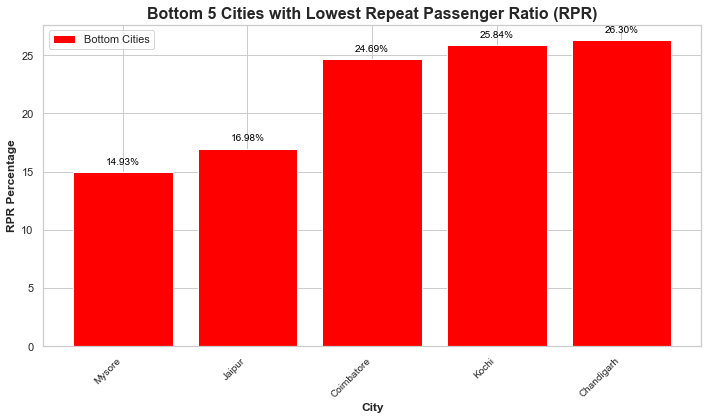

In [29]:

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

# Step 2: Define the SQL query for the top 5 cities
query_top = """
WITH RPR_City AS (
    SELECT 
        c.city_name,
        SUM(fps.repeat_passengers) AS total_repeat_passengers,
        SUM(fps.total_passengers) AS total_passengers,
        ROUND((SUM(fps.repeat_passengers) * 100.0) / SUM(fps.total_passengers), 2) AS rpr_percentage
    FROM trips_db.fact_passenger_summary fps
    JOIN trips_db.dim_city c 
        ON fps.city_id = c.city_id
    WHERE fps.month >= DATE_FORMAT(DATE_SUB(CURDATE(), INTERVAL 6 MONTH), '%%Y-%%m-01')
    GROUP BY c.city_name
)
SELECT 
    city_name,
    rpr_percentage
FROM RPR_City
ORDER BY rpr_percentage DESC
LIMIT 5;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df_top = pd.read_sql(query_top, engine)

# Step 4: Define the SQL query for the bottom 5 cities
query_bottom = """
WITH RPR_City AS (
    SELECT 
        c.city_name,
        SUM(fps.repeat_passengers) AS total_repeat_passengers,
        SUM(fps.total_passengers) AS total_passengers,
        ROUND((SUM(fps.repeat_passengers) * 100.0) / SUM(fps.total_passengers), 2) AS rpr_percentage
    FROM trips_db.fact_passenger_summary fps
    JOIN trips_db.dim_city c 
        ON fps.city_id = c.city_id
    WHERE fps.month >= DATE_FORMAT(DATE_SUB(CURDATE(), INTERVAL 6 MONTH), '%%Y-%%m-01')
    GROUP BY c.city_name
)
SELECT 
    city_name,
    rpr_percentage
FROM RPR_City
ORDER BY rpr_percentage ASC
LIMIT 5;
"""

# Step 5: Execute the query for bottom 5 cities
df_bottom = pd.read_sql(query_bottom, engine)

# Close the connection
engine.dispose()

# Step 6: Plotting top cities
plt.figure(figsize=(10, 6))
bars_top = plt.bar(df_top['city_name'], df_top['rpr_percentage'], color='green', label='Top Cities')

# Add data labels for top cities
for bar in bars_top:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # Position label at the center of the bar
        yval + 0.5,  # Slightly above the bar for clarity
        f'{yval:.2f}%',  # Display percentage with two decimal places
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.xlabel('City', fontsize=12, weight='bold')
plt.ylabel('RPR Percentage', fontsize=12, weight='bold')
plt.title('Top 5 Cities with Highest Repeat Passenger Ratio (RPR)', fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.legend()
plt.show()

# Step 7: Plotting bottom cities
plt.figure(figsize=(10, 6))
bars_bottom = plt.bar(df_bottom['city_name'], df_bottom['rpr_percentage'], color='red', label='Bottom Cities')

# Add data labels for bottom cities
for bar in bars_bottom:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # Position label at the center of the bar
        yval + 0.5,  # Slightly above the bar for clarity
        f'{yval:.2f}%',  # Display percentage with two decimal places
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.xlabel('City', fontsize=12, weight='bold')
plt.ylabel('RPR Percentage', fontsize=12, weight='bold')
plt.title('Bottom 5 Cities with Lowest Repeat Passenger Ratio (RPR)', fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.legend()
plt.show()


City Revenue Contribution

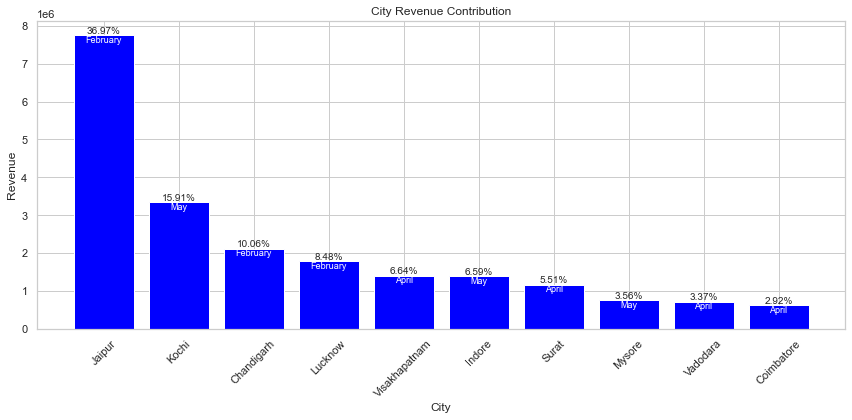

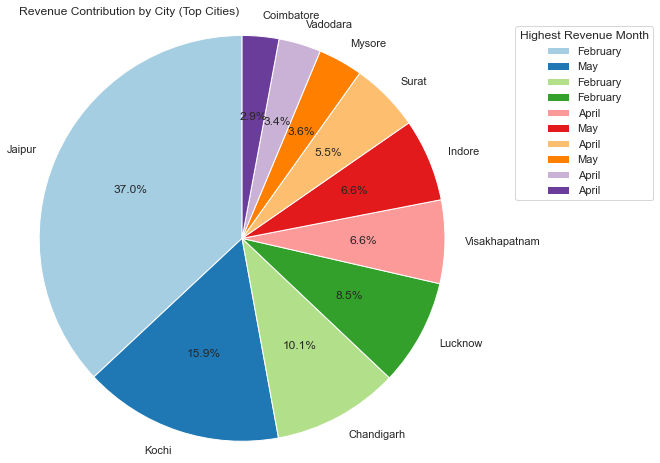

In [39]:
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_trips}")

# Step 2: Define the SQL query to get city revenue contribution
query = """
WITH CityRevenue AS (
    SELECT 
        c.city_name,
        d.month_name,
        d.start_of_month AS month_start, 
        SUM(f.fare_amount) AS total_revenue
    FROM trips_db.fact_trips f
    JOIN trips_db.dim_city c ON f.city_id = c.city_id
    JOIN trips_db.dim_date d ON f.date = d.date
    GROUP BY c.city_name, d.month_name, d.start_of_month
),
MaxRevenueMonth AS (
    SELECT 
        city_name,
        month_name AS highest_revenue_month,
        month_start,
        total_revenue,
        RANK() OVER (PARTITION BY city_name ORDER BY total_revenue DESC) AS revenue_rank
    FROM CityRevenue
),
CityTarget AS (
    SELECT 
        c.city_name,
        t.month AS target_month,
        t.total_target_trips,
        nt.target_new_passengers,
        rt.target_avg_passenger_rating
    FROM targets_db.monthly_target_trips t
    JOIN trips_db.dim_city c ON t.city_id = c.city_id
    LEFT JOIN targets_db.monthly_target_new_passengers nt 
        ON t.city_id = nt.city_id AND t.month = nt.month
    LEFT JOIN targets_db.city_target_passenger_rating rt 
        ON t.city_id = rt.city_id
),
CityContribution AS (
    SELECT 
        city_name,
        highest_revenue_month,
        month_start,
        total_revenue,
        ROUND(total_revenue * 100.0 / SUM(total_revenue) OVER (), 2) AS percentage_contribution
    FROM MaxRevenueMonth
    WHERE revenue_rank = 1
)
SELECT 
    cc.city_name,
    cc.highest_revenue_month,
    cc.total_revenue AS revenue,
    cc.percentage_contribution,
    ct.total_target_trips,
    ct.target_new_passengers,
    ct.target_avg_passenger_rating
FROM CityContribution cc
LEFT JOIN CityTarget ct 
    ON cc.city_name = ct.city_name AND cc.month_start = ct.target_month
ORDER BY cc.total_revenue DESC;
"""

# Step 3: Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Step 4: Close the connection
engine.dispose()

plt.figure(figsize=(12, 6))
bars = plt.bar(df['city_name'], df['revenue'], color='blue')
plt.xlabel('City')
plt.ylabel('Revenue')
plt.title('City Revenue Contribution')
plt.xticks(rotation=45)

# Annotating bars with percentage contribution and highest revenue month
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, 
             f"{df['percentage_contribution'][i]}%", 
             ha='center', va='bottom', fontsize=10)

    # Annotate the highest revenue month
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, 
             f"{df['highest_revenue_month'][i]}", 
             ha='center', va='top', fontsize=9, color='white')

plt.tight_layout()
plt.show()

# Step 6: Visualize with a pie chart showing revenue contribution percentage by city
plt.figure(figsize=(8, 8))
plt.pie(df['percentage_contribution'], labels=df['city_name'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

plt.title('Revenue Contribution by City (Top Cities)', loc='left')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding legends for highest revenue month
plt.legend(df['highest_revenue_month'], title="Highest Revenue Month", bbox_to_anchor=(1.1, 1), loc='upper left')
plt.show()
